In [1]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import os, gc 

from pinnPack import pinnUtils, physicsNN
from ssfmPack import utils

In [2]:
gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
    torch.randn(1).to('cuda') 

In [3]:
truthPulse = np.load('results/Cpulse.npy') 
truthTime = np.load('results/CtimeArr.npy') 
truthLength = np.load('results/ClengthArr.npy')

# Data Preparation

In [28]:
num_init = 500 #number of initial points
num_bound = 500 #number of boundary points, each
num_col = 7000 #number of collocation points 
num_val = 5000 #number of validation sampling points

In [29]:
#IC Function
def sechPulsePINN(time, amplitude, pulsewidth): 
    return amplitude/np.cosh(time/pulsewidth)

pulsewidth = 0.58
L = truthLength.max() #m
T = truthTime.max()

#Pulse Parameters 
parameters = {
    'L': L, #10m
    'T': T, #4ps
    'A0': np.sqrt(22.05),  # unit = (W^1/2)
    'pw': pulsewidth,  #0.58ps   
    'gamma': 18.4e-3,      # unit = (1/Wm)
    'beta2': -5.23e-3,     # unit = (s^2/m)
    'beta3': 4.27e-5,      # unit = (s^3/m)
    'alpha': 0.05*np.log(10)/10 # unit = Nepers/m
}
parameters['alpha'] = parameters['alpha']*L
parameters['beta2'] = parameters['beta2']*L/T**2
parameters['beta3'] = parameters['beta3']*L/T**3
parameters['gamma'] = parameters['gamma']*L

#Training Dataset 
#T domain is normalized into (-1,1); Z domain is normalized into (0,1) 
t_init = np.linspace(-T/T,T/T,num_init).reshape(-1,1) #Initial
x_init = np.zeros((num_init, 1))
u_init = sechPulsePINN(t_init, parameters['A0'], parameters['pw']/T).reshape(-1,1)
tx_init = (t_init, x_init)
uv_init = (u_init, np.zeros_like(u_init))

tU_bound = np.full((num_bound,1), -T/T, dtype = float)
xU_bound = pinnUtils.generate_points(0, L/L, num_bound)
tL_bound = np.full((num_bound, 1,), T/T, dtype = float) 
xL_bound = pinnUtils.generate_points(0, L/L, num_bound)
txU_bound = (tU_bound, xU_bound)
txL_bound = (tL_bound, xL_bound)

tx_col = pinnUtils.generate_points(np.array([-T/T,0]),np.array([T/T,L/L]),num_col) #Collocation
tx_col_add = pinnUtils.generate_points(np.array([-0.25*T/T,0]),np.array([0.25*T/T,L/L]),2*num_col) #Collocation
tx_col = np.concatenate([tx_col, tx_col_add], axis = 0)
tx_col = (tx_col[:,0].reshape(-1,1), tx_col[:,1].reshape(-1,1))
#Validation Dataset 
tx_val, uv_val = pinnUtils.ssfm_sampling(truthTime/T, truthLength/L, truthPulse, num_val, clipRange = 400, normalized = False)

In [30]:
tx_col[0].shape

(21000, 1)

# Check

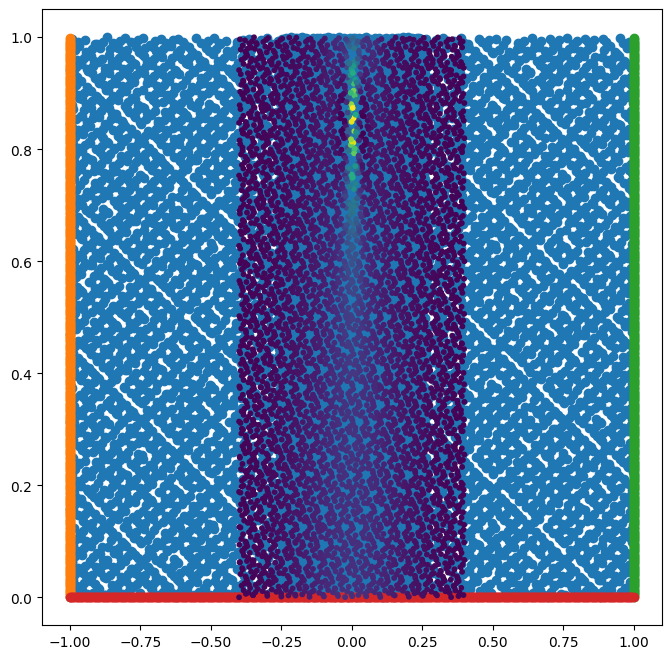

In [31]:
fig = plt.figure(figsize = (8,8))
plt.scatter(tx_col[0][:,-1], tx_col[1][:,-1])
plt.scatter(tU_bound[:,-1], xU_bound[:,-1])
plt.scatter(tL_bound[:,-1], xL_bound[:,-1])
plt.scatter(t_init[:,-1], x_init[:,-1])
amplitude = uv_val[0][:,0]**2 + uv_val[1][:,0]**2
plt.scatter(tx_val[0][:, 0], tx_val[1][:, 0], c=amplitude, cmap='viridis', s=10)

In [32]:
print(f"a = {parameters['alpha']}")
print(f"b = {parameters['beta2']}")
print(f"d = {parameters['beta3']}")
print(f"c = {parameters['gamma']}")

a = 0.14966803104461301
b = -0.008483544189337031
d = 2.446637652925581e-05
c = 0.2392


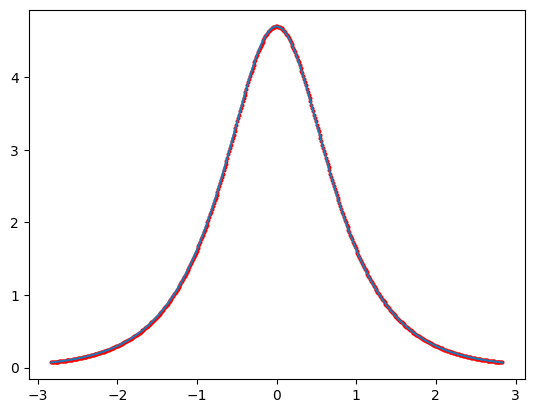

In [33]:
plt.scatter(np.sort(t_init[:,0])*T,
            sechPulsePINN(np.sort(t_init[:,0])*T, parameters['A0'], parameters['pw']),
            color='red', marker='.', s=15)
plt.plot(truthTime, np.abs(truthPulse[0]))

# Vanilla PINN

In [ ]:
path = 'results/complex/vanilla'
layers = [2,172,172,172,172,2] 
optimizer = 'Adam'
activation = 'tanh' 

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2)
piNN.optimizer = pinnUtils.choose_optimizer('adam', piNN.dnn.parameters(), lr = 5e-5)
piNN.train(epochs =25000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

[DNN] training:   0% 0/25000 [00:00<?, ?it/s]/home/andikoputrapk/.conda/envs/myenv/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[DNN] training:  11% 2856/25000 [10:30<1:21:21,  4.54it/s, loss=0.192, mse=2.64]

# Causal Decay

[DNN/causal] training:   0% 0/25000 [00:00<?, ?it/s]/home/andikoputrapk/.conda/envs/myenv/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[DNN/causal] training: 100% 25000/25000 [15:21<00:00, 27.13it/s, loss=0.000718, mse=0.156]


Training using LBFGS


[DNN/causal] training: 100% 1/1 [03:44<00:00, 224.77s/it, loss=2.14e-5, mse=0.156]


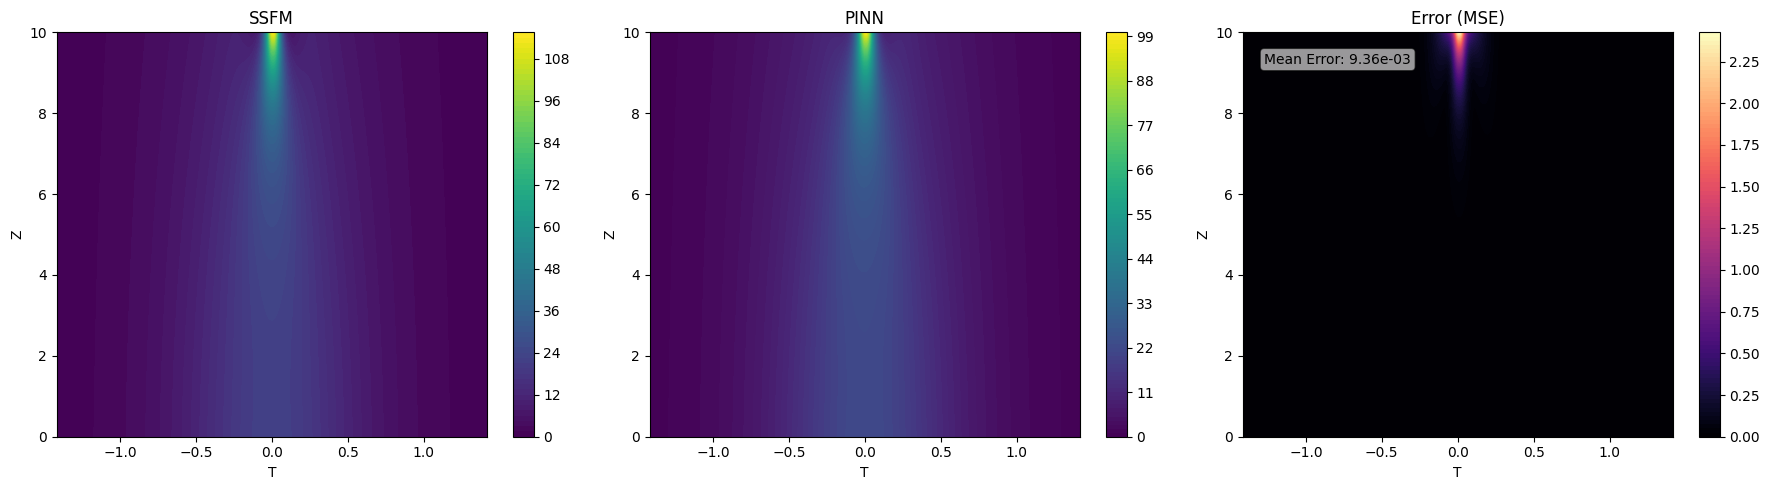

In [9]:
path = 'results/complex/causal'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2, causal_decay = True)
piNN.train(epochs =25000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

# Curriculum

In [16]:
path = 'results/complex/curriculum'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 
curriculum = {
    'curr_on': 'gamma',
    'curr_initval': 0.1,       # Start with a linear system
    'curr_steps': 5,           
    'version': 2,              
    'curr_epochs': 4000         # You can tweak this based on total epochs
}

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2,
                          curriculum = curriculum)
piNN.train(epochs =25000, curriculum = curriculum)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.curriculum = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

Using curriculum learning on param gamma with target 0.184



[CURR] Training on gamma: 0.14:  90% 6332/7000 [16:29<01:44,  6.40it/s, loss=0.00152, mse=1.37]


KeyboardInterrupt: 

# Curriculum-Causal

In [ ]:
path = 'results/complex/curriculum-causal'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 
curriculum = {
    'curr_on': 'gamma',
    'curr_initval': 0.1,       # Start with a linear system
    'curr_steps': 5,           # 5 stages of curriculum
    'version': 2,              # Fixed steps per stage
    'curr_epochs': 4000         # You can tweak this based on total epochs
}

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2, causal_decay = False,
                          curriculum = curriculum)
piNN.train(epochs =25000, curriculum = curriculum)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.curriculum = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

Using curriculum learning on param gamma with target 0.184



[CURR] Training on gamma: 0.1: 100% 4000/4000 [10:24<00:00,  6.40it/s, loss=0.000501, mse=3.13]
[CURR] Training on gamma: 0.121: 100% 4000/4000 [10:25<00:00,  6.40it/s, loss=0.000573, mse=2.1] 
[CURR] Training on gamma: 0.142:  12% 494/4000 [01:17<09:16,  6.30it/s, loss=0.0054, mse=1.64] 

# Progressive

Progressive PT learning is used for 4 steps


[PROG] Training on Index: 1:   0% 0/5000 [00:00<?, ?it/s]/home/andikoputrapk/.conda/envs/myenv/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[PROG] Training on Index: 1: 100% 5000/5000 [04:05<00:00, 20.40it/s, loss=0.000184, mse=2.46]
[PROG] Training on Index: 2: 100% 5000/5000 [03:44<00:00, 22.25it/s, loss=0.000405, mse=1.1] 
[PROG] Training on Index: 3: 100% 5000/5000 [04:55<00:00, 16.90it/s, loss=0.00257, mse=0.423]
[PROG] Training on Index: 4: 100% 10000/10000 [12:04<00:00, 13.81it/s, loss=0.00186, mse=0.204]


Training using LBFGS


[DNN] training: 100% 1/1 [24:10<00:00, 1450.66s/it, loss=0.000337, mse=0.203]


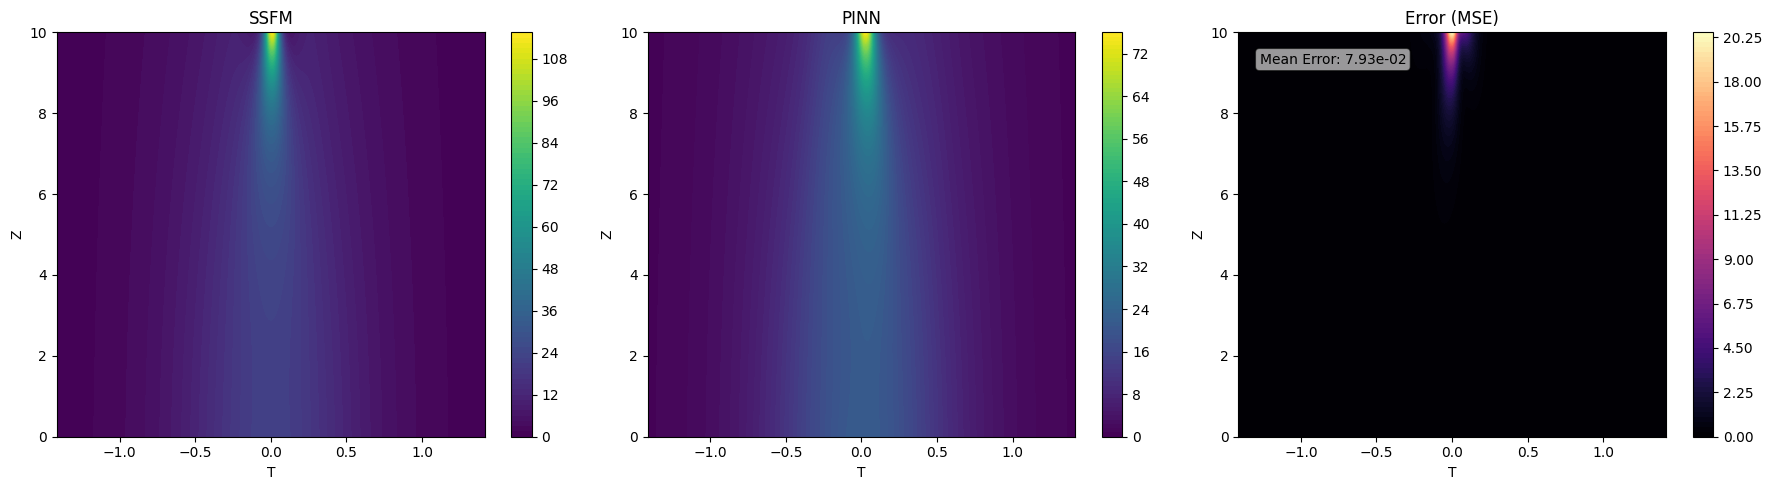

In [9]:
path = 'results/complex/progressive'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 
progressive = {
    'domain_stages': 4,       # 4 stages of progressive
    'sampling': 150,         
    'version': 2,              # Fixed steps per stage
    'prog_epochs': 5000        # You can tweak this based on total epochs
}


piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2,
                          progressive = progressive)

piNN.train(epochs =25000, progressive = progressive)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.progressive = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

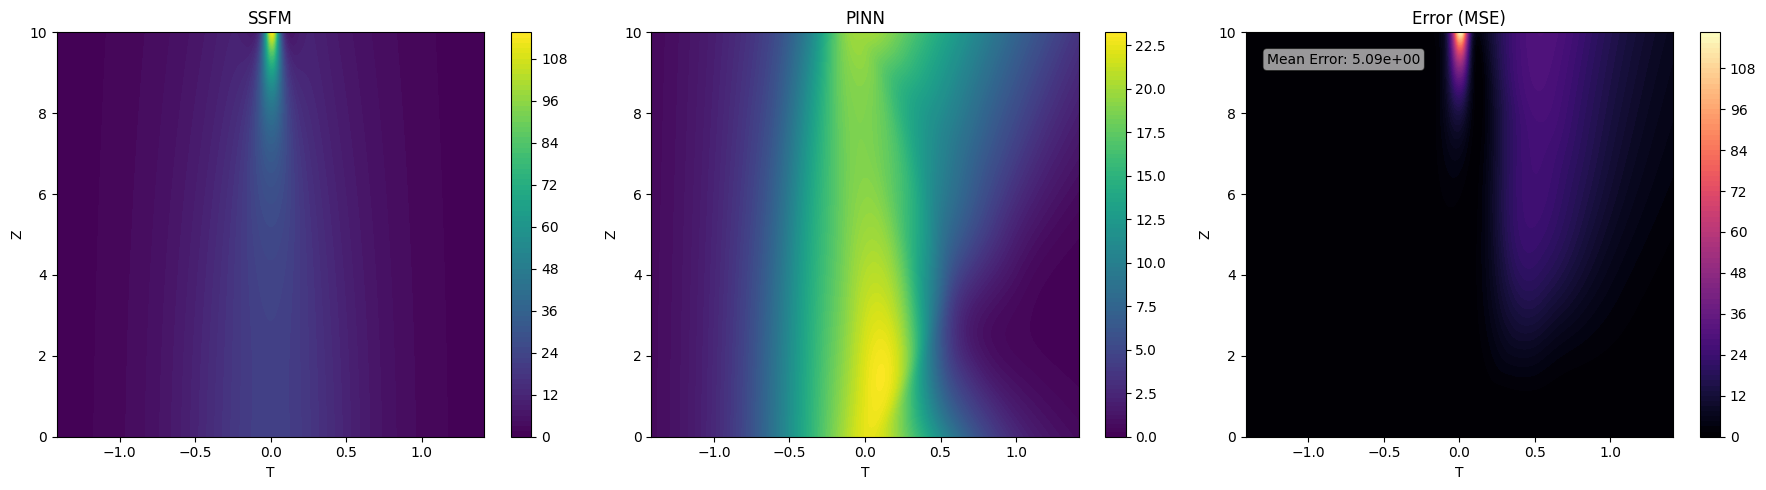

In [16]:
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = None)

311

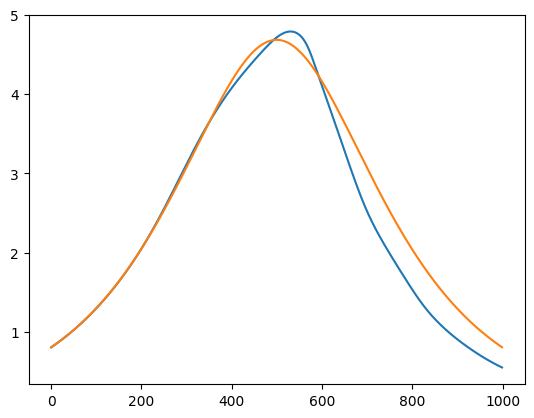

In [24]:
plt.plot(np.abs(predPulse[400]))
plt.plot(np.abs(expPulse[400]))

311
311
309
300
308

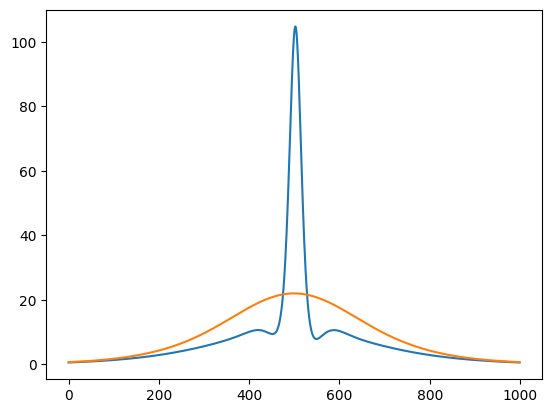

In [20]:
predPulse = np.load('results/complex/curriculum-causal/predPulse.npy')
plt.plot(np.abs(predPulse[-1])**2)
plt.plot(np.abs(predPulse[0])**2)